<a href="https://colab.research.google.com/github/wlsamchen01/Python_for_Stocks/blob/main/portfolio_optimization_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
!pip install PyPortfolioOpt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 2.8 MB/s 


In [3]:
#title Default title text
# import libraries

# for reading yahoo finance
from pandas_datareader import data as web
import yfinance as yf
yf.pdr_override()

# regular stuff
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.style.use('fivethirtyeight')
rcParams.update({'text.color' : "blue",
                     'axes.labelcolor' : "blue"})

# PyPortfolioOpt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [4]:
# get the stock tickers in the portfolio
assets = sorted(['META', 'HACK', 'SPY', 'COST','AMD','GM','MSFT','GOVT'])

In [5]:
# get the stock portfolio starting and end date
start_date = '2019-01-01'
today = datetime.today().strftime('%Y-%m-%d')
today

'2022-08-25'

In [6]:
# create a dataframe to store the adjusted close prices of the stocks
df = pd.DataFrame()
# grab the stock prices using web.DataReader. below code adds the dates as the index
for stock in assets:
  df[stock] = web.DataReader(stock, data_source='yahoo', start=start_date, end=today)['Adj Close']

df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,AMD,COST,GM,GOVT,HACK,META,MSFT,SPY
Date,,,,,,,,
2019-01-02,18.830000,193.501404,31.893360,23.431620,32.669365,135.679993,97.147697,236.102341
2019-01-03,17.049999,189.400040,30.575533,23.563627,31.791948,131.740005,93.573845,230.468277
2019-01-04,19.000000,194.900009,31.599459,23.441048,32.874096,137.949997,97.925880,238.187973
2019-01-07,20.570000,195.618271,32.575977,23.393896,33.595531,138.050003,98.050766,240.066040
2019-01-08,20.750000,197.083008,33.002617,23.346756,34.307217,142.529999,98.761703,242.321487
...,...,...,...,...,...,...,...,...
2022-08-18,100.440002,560.960022,38.720001,23.920000,51.150002,174.660004,290.170013,427.890015
2022-08-19,95.949997,554.530029,39.700001,23.809999,50.090000,167.960007,286.149994,422.140015
2022-08-22,92.839996,545.469971,38.549999,23.750000,49.139999,163.050003,277.750000,413.350006


# Plot Adj. Close Prices

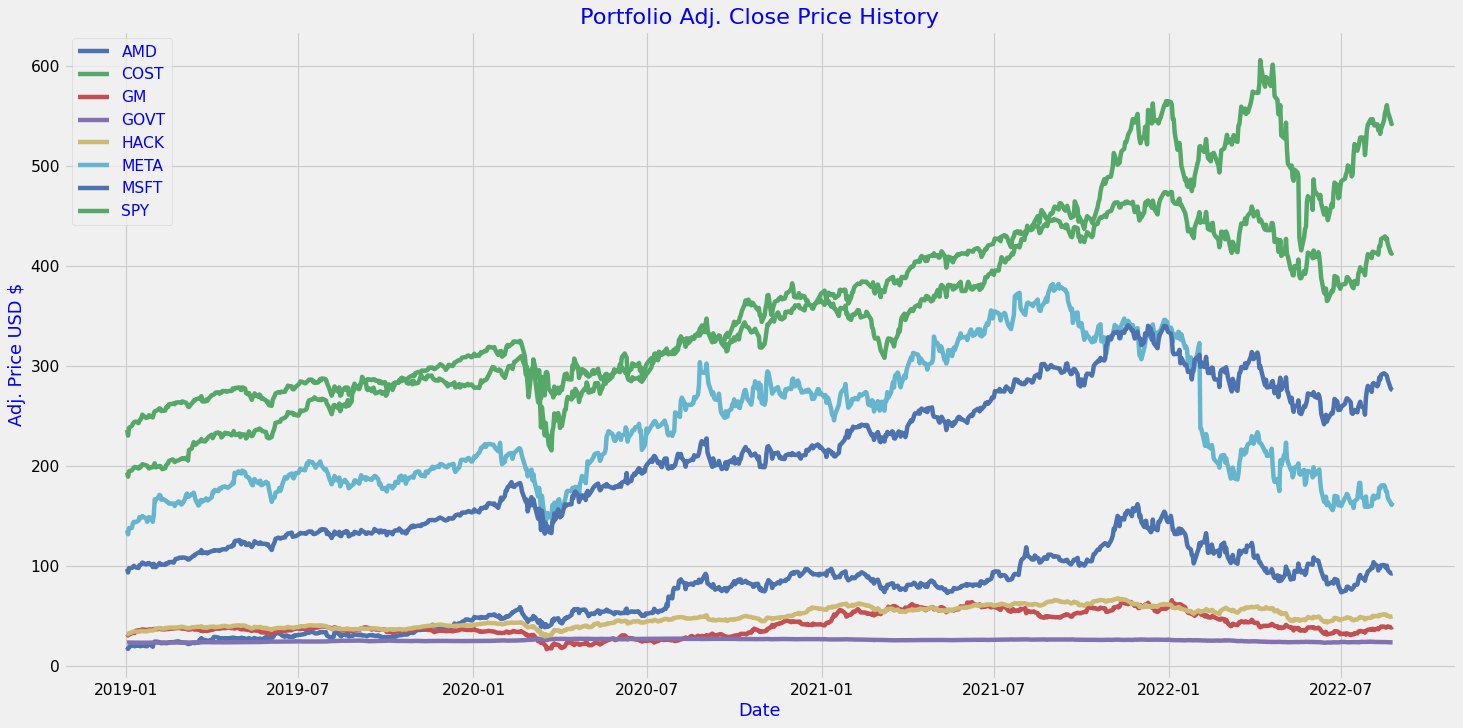

In [7]:
title = 'Portfolio Adj. Close Price History'

# get the stocks
my_stocks = df

# create and plot the graph
plt.figure(figsize=(20, 10), dpi=80)

for c in my_stocks.columns.values:
  plt.plot(my_stocks[c],label=c)



plt.title(title)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Adj. Price USD $', fontsize=16)
plt.legend(my_stocks.columns.values, loc='upper left')
plt.show()

## Portfolio Weights

In [8]:
# assign weights to the stocks
# we set equal weights first to assess their individual performances
equal_weight = 1/len(assets)
weights = np.array([equal_weight]*len(assets))
weights

array([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125])

## Returns and Portfolio Volatility

In [9]:
# create a dataframe of daily simple returns
returns_df = df.pct_change()

# create an annualised covariance matrix
cov_matrix_annual = returns_df.cov()*252
# This is the method used by PyPortfolioOpt https://quant.stackexchange.com/questions/48739/why-annualizing-sampled-covariance-matrix-changes-stock-weight-vector

# calculate the portfolio variance
port_variance = np.dot(weights.T, np.dot(cov_matrix_annual,weights))
print('Portfolio variance: ', port_variance)

# calculate the portfolio volatility (standard deviation)
port_volatility = np.sqrt(port_variance)
print('Portfolio volatility (Standard Deviation): ', port_volatility)

Portfolio variance:  0.05620515620751135
Portfolio volatility (Standard Deviation):  0.2370762666474891


### Annualising returns

In [10]:
# Add 1 to the returns
return_cols = list(returns_df.columns)
returns_with_one = returns_df.copy()
returns_with_one +=1
returns_with_one

,AMD,COST,GM,GOVT,HACK,META,MSFT,SPY
Date,,,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,0.905470,0.978804,0.958680,1.005634,0.973143,0.970961,0.963212,0.976137
2019-01-04,1.114370,1.029039,1.033488,0.994798,1.034038,1.047138,1.046509,1.033496
2019-01-07,1.082632,1.003685,1.030903,0.997989,1.021945,1.000725,1.001275,1.007885
2019-01-08,1.008751,1.007488,1.013097,0.997985,1.021184,1.032452,1.007251,1.009395
...,...,...,...,...,...,...,...,...
2022-08-18,1.022082,1.008341,1.008333,1.000837,1.006295,0.998913,0.996052,1.002906
2022-08-19,0.955297,0.988538,1.025310,0.995401,0.979277,0.961640,0.986146,0.986562
2022-08-22,0.967587,0.983662,0.971033,0.997480,0.981034,0.970767,0.970645,0.979178


Using the expected_returns.mean_historical_return() on df to get the geometric mean of the daily return of each asset, and annualising it. As per documentation: https://pyportfolioopt.readthedocs.io/en/latest/ExpectedReturns.html

Since we are equally weighted, we can simply use the simple mean of the above.

In [11]:
portfolio_simple_annual_return = expected_returns.mean_historical_return(df)\
                                  .mean()
portfolio_simple_annual_return

0.20131990370529512

# Expected annualised daily return, volatility and variance

In [12]:


# so the expected annual return, volatility (risk), and variance
percent_var = str(round(port_variance,3)*100)+'%'
percent_vola = str(round(port_volatility,3)*100)+'%'
percent_ret = str(round(portfolio_simple_annual_return,3)*100)+'%'

print('Expected annualised daily return: '+percent_ret)
print('Annual volatility/ risk: '+percent_vola)
print('Annual variance: '+percent_var)



Expected annualised daily return: 20.1%
Annual volatility/ risk: 23.7%
Annual variance: 5.6000000000000005%


# Maximise Sharpe Ratio - aka the tangency porfolio

In [13]:


# portfolio optimisation

# calculate the expected returns and the annualised sample covariance matrix of asset returns

# you just need the original asset prices dataframe as input
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# mean-variance optimisation
# weights bounded to between 0 and 1 - this means we are not allowed to go short
ef = EfficientFrontier(mu, S, weight_bounds=(0,1))
# set weights to max sharpe ratio
# risk_free_weight defaulted to 0.02 or 2%
weights = ef.max_sharpe()
# round weights and clip near-zeros
cleaned_weights = ef.clean_weights()
print(weights, '\n')
print(cleaned_weights, '\n')
ef.portfolio_performance(verbose=True)

OrderedDict([('AMD', 0.1566522002965598), ('COST', 0.7830368859293372), ('GM', 0.0), ('GOVT', 0.0), ('HACK', 0.0), ('META', 0.0), ('MSFT', 0.0603109137741031), ('SPY', 0.0)]) 

OrderedDict([('AMD', 0.15665), ('COST', 0.78304), ('GM', 0.0), ('GOVT', 0.0), ('HACK', 0.0), ('META', 0.0), ('MSFT', 0.06031), ('SPY', 0.0)]) 

Expected annual return: 36.3%
Annual volatility: 25.5%
Sharpe Ratio: 1.34


(0.36251741906515156, 0.2547286555858709, 1.3446363868147)

# Discrete Allocation

In [14]:
#from pypfopt.discrete_allocation
latest_prices = get_latest_prices(df)

weights = cleaned_weights

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = 50000)
allocation, leftover = da.lp_portfolio()

print('Discrete Allocation: ', allocation, '\n')
print(f'Funds Remaining:  ${leftover}')

Discrete Allocation:  {'AMD': 84, 'COST': 72, 'MSFT': 11} 

Funds Remaining:  $65.1517333984375


# Efficient Risk - Maximise return for a given risk

What if we want to limit ourselves to a certain risk/volatility, say 20%. What would be our optimal portfolio?

In [15]:
# reinitialise
ef = EfficientFrontier(mu, S, weight_bounds=(0,1))

# set weights to efficient risk
# set the target volatility to 0.2
weights = ef.efficient_risk(target_volatility=0.2)
cleaned_weights = ef.clean_weights()
print(cleaned_weights,'\n')
ef.portfolio_performance(verbose=True)



OrderedDict([('AMD', 0.11844), ('COST', 0.61765), ('GM', 0.0), ('GOVT', 0.20524), ('HACK', 0.0), ('META', 0.0), ('MSFT', 0.05867), ('SPY', 0.0)]) 

Expected annual return: 28.7%
Annual volatility: 20.0%
Sharpe Ratio: 1.34


(0.28733801600013076, 0.20000000003115753, 1.336690079792414)

In [16]:
# discrete portfolio
latest_prices = get_latest_prices(df)
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=50000)

allocation, leftover = da.lp_portfolio()
print('Discrete Allocation: ', allocation, '\n')
print(f'Funds remaining: ${leftover}')

Discrete Allocation:  {'AMD': 64, 'COST': 57, 'GOVT': 434, 'MSFT': 10} 

Funds remaining: $79.74153518676758


As expected, we reduce our volatility by adding more government bonds to our portfolio.

# Efficient Risk - Maximise return for a given risk

Conversely, we can  minimise our risk for a targeted return

In [17]:
# reinitialise
ef = EfficientFrontier(mu, S, weight_bounds=(0,1))

# set weights for a targeted return
# set the targeted return to to 0.20
weights = ef.efficient_return(target_return=0.20)
cleaned_weights = ef.clean_weights()
print(cleaned_weights, '\n')
ef.portfolio_performance(verbose=True)

OrderedDict([('AMD', 0.07814), ('COST', 0.42269), ('GM', 0.0), ('GOVT', 0.44642), ('HACK', 0.0), ('META', 0.0), ('MSFT', 0.05275), ('SPY', 0.0)]) 

Expected annual return: 20.0%
Annual volatility: 13.8%
Sharpe Ratio: 1.30


(0.19999999999999996, 0.13796198266989085, 1.304707257148484)

In [18]:
# discrete portfolio
latest_prices = get_latest_prices(df)
# round weights and clip near-zeros
weights = cleaned_weights
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = 50000)

allocation, leftover = da.lp_portfolio()
print('Discrete Allocation: ', allocation, '\n')
print(f'Funds remaining: ${leftover}')

Discrete Allocation:  {'AMD': 43, 'COST': 39, 'GOVT': 944, 'MSFT': 9} 

Funds remaining: $19.32128143310547


# Minimise Volatility
We can also find the portfolio that has the minimum volatility:

In [19]:
# reinitialise
ef = EfficientFrontier(mu, S, weight_bounds=(0,1))

# min vol
weights = ef.min_volatility()
cleaned_weights = ef.clean_weights()
print(cleaned_weights, '\n')
ef.portfolio_performance(verbose=True)

OrderedDict([('AMD', 0.0), ('COST', 0.00069), ('GM', 0.00484), ('GOVT', 0.88594), ('HACK', 0.0), ('META', 0.0), ('MSFT', 0.0), ('SPY', 0.10853)]) 

Expected annual return: 2.1%
Annual volatility: 4.9%
Sharpe Ratio: 0.02


(0.02083124771306689, 0.04865069295707649, 0.017086040558564775)

In [20]:
# discrete portfolio
latest_prices = get_latest_prices(df)
# round weights and clip near-zeros
weights = cleaned_weights
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = 50000)

allocation, leftover = da.lp_portfolio()
print('Discrete Allocation: ', allocation, '\n')
print(f'Funds remaining: ${leftover}')

Discrete Allocation:  {'GM': 7, 'GOVT': 1874, 'SPY': 13} 

Funds remaining: $27.440540313720703


If you want to minimise risk/volatility, buy mostly goverment bonds : 88.5% of our portfolio allocation! And a small part to SPY and GM.

# Add Extra Constraints

We can add extra constraints to our portfolio such as:

- sector constraint via a sector_mapper
- sector minimumn via sector_lower
- sector maximum via sector_upper
- minimum allocation to a specific stock via ef.add_constraint()

In [21]:
print(mu)

AMD     0.549039
COST    0.327579
GM      0.058630
GOVT    0.002550
HACK    0.122566
META    0.052109
MSFT    0.331659
SPY     0.166428
dtype: float64


In [22]:
# reinitialise
ef = EfficientFrontier(mu, S, weight_bounds=(0,1))

# add 5% minimum holding constraint to HACK
ef.add_constraint(lambda x:x[4]>=0.05)

# add sector mapper
sector_mapper = {
    'AMD': 'Semi-Conductors'
    ,'COST': 'Retail'
    ,'GM': 'Car'
    ,'GOVT': 'Government Bonds'
    ,'HACK': 'Technology'
    ,'META': 'Technology'
    ,'MSFT': 'Technology'
    ,'SPY': 'Market'
}

# sector minimum
sector_lower = {'Market': 0.2} # at least 20% to SPY

# maximum allocations to each sector
sector_upper = {
    'Semi-Conductors': 0.2
    ,'Government Bonds': 0.2
    ,'Technology': 0.5
}

ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)

# set weights to efficient risk
# set the target volatility to 0.2
weights = ef.efficient_risk(target_volatility=0.2)
cleaned_weights = ef.clean_weights()
print(cleaned_weights, '\n')
ef.portfolio_performance(verbose=True)

latest_prices = get_latest_prices(df)
# round weights and clip near-zeros
weights = cleaned_weights
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = 50000)

allocation, leftover = da.lp_portfolio()
print('Discrete allocation:', allocation,'\n')
print(f'Funds Remaining: ${leftover}')

OrderedDict([('AMD', 0.08503), ('COST', 0.53997), ('GM', 0.0), ('GOVT', 0.125), ('HACK', 0.05), ('META', 0.0), ('MSFT', 0.0), ('SPY', 0.2)]) 

Expected annual return: 26.3%
Annual volatility: 20.0%
Sharpe Ratio: 1.22
Discrete allocation: {'AMD': 45, 'COST': 50, 'GOVT': 264, 'HACK': 50, 'SPY': 24} 

Funds Remaining: $5.471153259277344
